<a id="3"></a> <br>
# **Bayesian Optimization with LightGBM**
<br>
Now I am going to prepare data for modeling and a Baysian Optimization function. You can put more parameters (ex. lambda_l1 and lambda_l2) into the function.  

In [4]:
y=train['target']
X=train.drop(['ID_code','target'],axis=1)

In [5]:
%%time

def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=3, random_seed=6,n_estimators=10000, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)
    # parameters
    def lgb_eval(learning_rate,num_leaves, feature_fraction, bagging_fraction, max_depth, max_bin, min_data_in_leaf,min_sum_hessian_in_leaf,subsample):
        params = {'application':'binary', 'metric':'auc'}
        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['max_bin'] = int(round(max_depth))
        params['min_data_in_leaf'] = int(round(min_data_in_leaf))
        params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
        params['subsample'] = max(min(subsample, 1), 0)
        
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        return max(cv_result['auc-mean'])
     
    lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.01, 1.0),
                                            'num_leaves': (24, 80),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.8, 1),
                                            'max_depth': (5, 30),
                                            'max_bin':(20,90),
                                            'min_data_in_leaf': (20, 80),
                                            'min_sum_hessian_in_leaf':(0,100),
                                           'subsample': (0.01, 1.0)}, random_state=200)

    
    #n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.
    #init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.
    
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    model_auc=[]
    for model in range(len( lgbBO.res)):
        model_auc.append(lgbBO.res[model]['target'])
    
    # return best parameters
    return lgbBO.res[pd.Series(model_auc).idxmax()]['target'],lgbBO.res[pd.Series(model_auc).idxmax()]['params']

opt_params = bayes_parameter_opt_lgb(X, y, init_round=5, opt_round=10, n_folds=3, random_seed=6,n_estimators=10000)

|   iter    |  target   | baggin... | featur... | learni... |  max_bin  | max_depth | min_da... | min_su... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8425   |  0.9895   |  0.2812   |  0.5985   |  49.98    |  24.1     |  20.17    |  35.74    |  74.94    |  0.4615   |
|  2        |  0.8033   |  0.9964   |  0.7939   |  0.9862   |  84.63    |  12.59    |  70.77    |  12.12    |  67.99    |  0.258    |
|  3        |  0.8283   |  0.8192   |  0.8548   |  0.8278   |  56.28    |  26.84    |  54.7     |  45.01    |  62.09    |  0.4252   |
|  4        |  0.8648   |  0.9281   |  0.5869   |  0.1144   |  87.62    |  23.97    |  60.78    |  32.93    |  25.48    |  0.8056   |
|  5        |  0.8491   |  0.9946   |  0.3264   |  0.6526   |  38.59    |  9.692    |  45.14    |  66.6     |  52.98    |  0.8559   |
|  6        |  0.7693   |  0.8      |  0.9      |  0.01     | 

Here is my optimal parameter for LightGBM. 

In [6]:
opt_params[1]["num_leaves"] = int(round(opt_params[1]["num_leaves"]))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['min_data_in_leaf'] = int(round(opt_params[1]['min_data_in_leaf']))
opt_params[1]['max_bin'] = int(round(opt_params[1]['max_bin']))
opt_params[1]['objective']='binary'
opt_params[1]['metric']='auc'
opt_params[1]['is_unbalance']=True
opt_params[1]['boost_from_average']=False
opt_params=opt_params[1]
opt_params


{'bagging_fraction': 0.8360034886892089,
 'feature_fraction': 0.1,
 'learning_rate': 0.09520535659597275,
 'max_bin': 20,
 'max_depth': 23,
 'min_data_in_leaf': 20,
 'min_sum_hessian_in_leaf': 100.0,
 'num_leaves': 80,
 'subsample': 0.03708289604738438,
 'objective': 'binary',
 'metric': 'auc',
 'is_unbalance': True,
 'boost_from_average': False}

<a id="4"></a> <br>
# **Training LightGBM** <br> <br>

Based on the parameter from the previous step, I am going to train LightGBM. 

In [7]:
%%time 

target=train['target']
features= [c for c in train.columns if c not in ['target','ID_code']]


folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=31416)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 15000
    clf = lgb.train(opt_params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 250)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))


Fold 0
Training until validation scores don't improve for 250 rounds.
[500]	training's auc: 0.99302	valid_1's auc: 0.890775
Early stopping, best iteration is:
[574]	training's auc: 0.99539	valid_1's auc: 0.891117
Fold 1
Training until validation scores don't improve for 250 rounds.
[500]	training's auc: 0.992939	valid_1's auc: 0.884994
Early stopping, best iteration is:
[529]	training's auc: 0.993973	valid_1's auc: 0.885707
Fold 2
Training until validation scores don't improve for 250 rounds.
[500]	training's auc: 0.993024	valid_1's auc: 0.881803
Early stopping, best iteration is:
[370]	training's auc: 0.985547	valid_1's auc: 0.882169
Fold 3
Training until validation scores don't improve for 250 rounds.
[500]	training's auc: 0.992961	valid_1's auc: 0.884717
Early stopping, best iteration is:
[594]	training's auc: 0.995811	valid_1's auc: 0.885352
Fold 4
Training until validation scores don't improve for 250 rounds.
[500]	training's auc: 0.992925	valid_1's auc: 0.889698
Early stopping, b

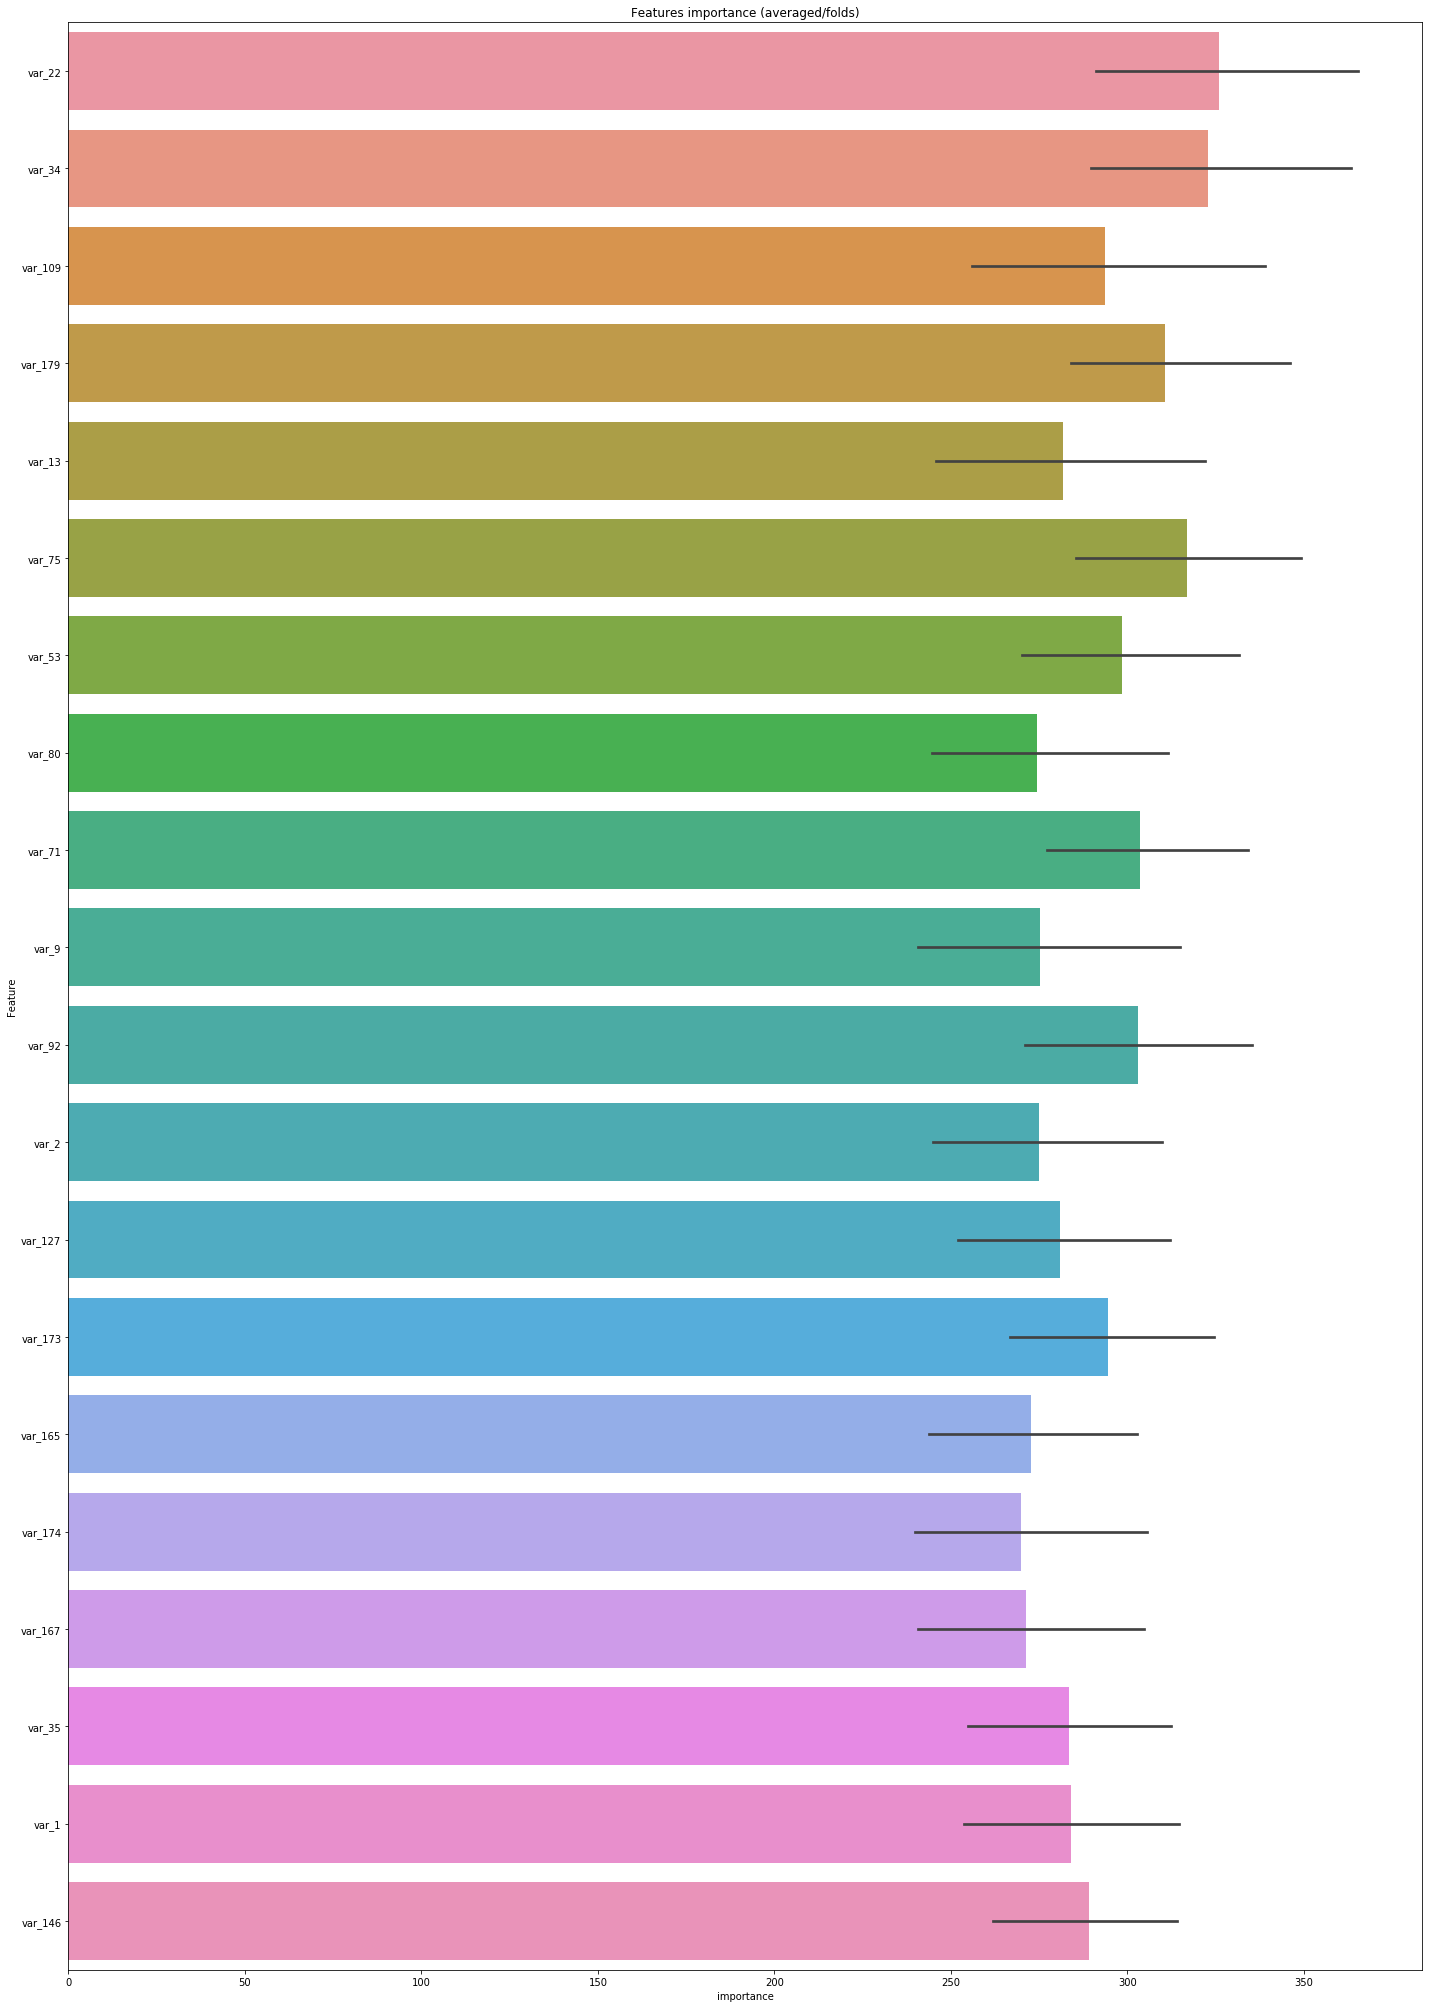

In [8]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:20].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(20,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('Feature_Importance.png')

<a id="5"></a> <br>
# **Understanding the Model Better**
<br>

To get an overview of which features are most important for a model, we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. [(source)](https://github.com/slundberg/shap) The color represents the feature value (red high, blue low). This reveals for example that a high var_139 lowers the probability of being a customer who will make a specific transaction in the future. 

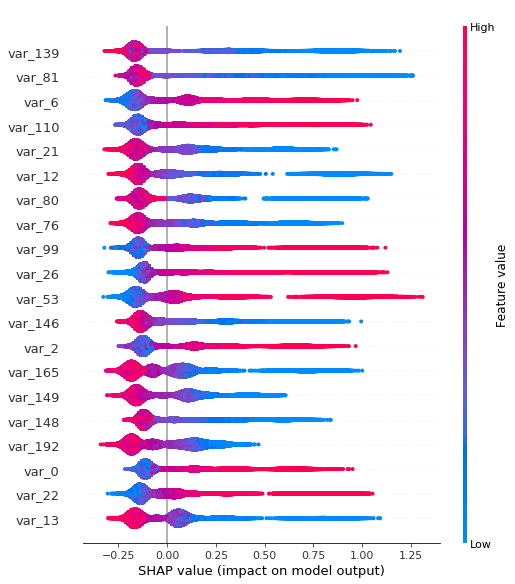

In [9]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

We can also plot a tree from the model and see each tree! 

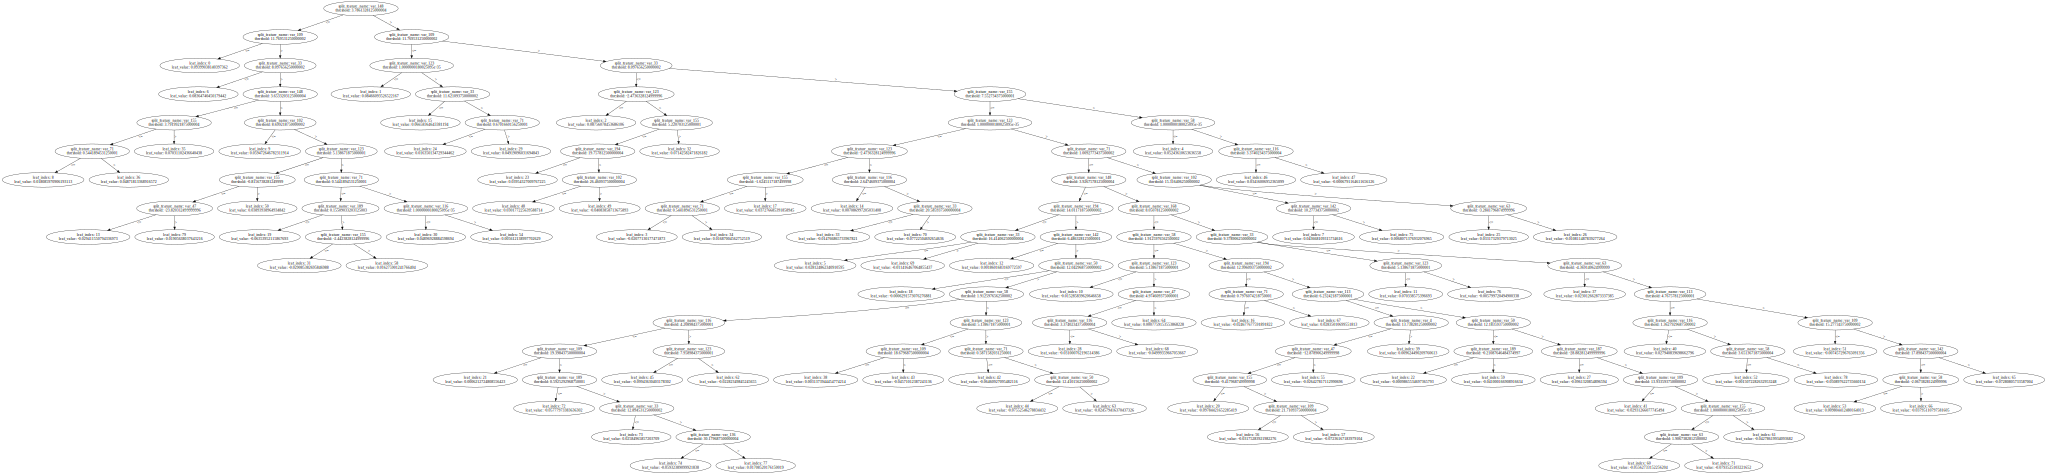

In [10]:
#tree visualization
graph = lgb.create_tree_digraph(clf, tree_index=3, name='Tree3' )
graph.graph_attr.update(size="110,110")
graph